In [1]:
import numpy as np
import colorsys
import h5py
from PIL import Image
import io
import b3d
import matplotlib.pyplot as plt
import time
import os

In [2]:
# paths for reading physion metadata
physion_assets_path = os.path.join(
    b3d.get_root_path(),
    "assets/physion/",)

resnet_inference_path = os.path.join(
    b3d.get_root_path(),
    "resnet_results/",)

stim_name = 'pilot_it2_collision_assorted_targets_box_0003'

hdf5_file_path = os.path.join(physion_assets_path,
    f"{stim_name}.hdf5",
)

mesh_file_path = os.path.join(physion_assets_path,
    f"all_flex_meshes/core",
)

json_file_path = os.path.join(resnet_inference_path,
    f"{stim_name}.json",
)

im_width = 350
im_height = 350

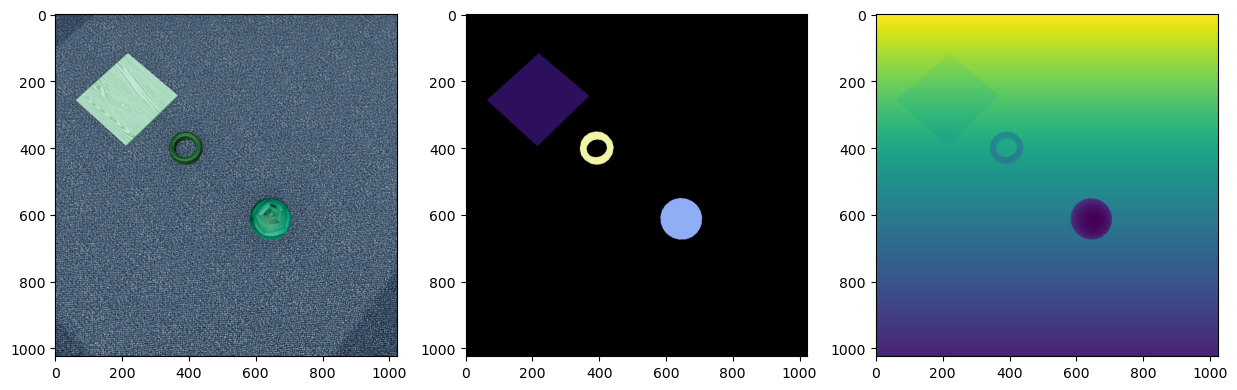

In [3]:
h5file = h5py.File(hdf5_file_path, 'r')

initial_position = np.array(h5file['static']['initial_position'])

cam_matrix = h5file['frames']['0000']['camera_matrices']['camera_matrix_cam0'][:]
cam_matrix = cam_matrix.reshape(4, 4)

object_ids = np.array(h5file['static']['object_ids'])
object_segmentation_colors = np.array(h5file['static']['object_segmentation_colors'])

im = np.flip(np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_img_cam0'][:]))), 1)
# im = np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_img_cam0'][:])))

im_seg = np.flip(np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_id_cam0'][:]))), 1)
# im_seg = np.array(Image.open(io.BytesIO(h5file['frames']['0000']['images']['_id_cam0'][:])))
colors = h5file['static']['object_segmentation_colors'][:][0]

depth_map = np.flip(np.array(h5file['frames']['0000']['images']['_depth_cam0']), 1)
# depth_map = np.array(h5file['frames']['0000']['images']['_depth_cam0'])

fig = plt.figure(figsize=[15, 5])
ax = fig.add_subplot(131)
ax.imshow(im)

ax = fig.add_subplot(132)
ax.imshow(im_seg)

ax = fig.add_subplot(133)
ax.imshow(depth_map)

In [4]:
with h5py.File(hdf5_file_path, "r") as f:
    # extract object info
    colors = np.array(f['static']['color'])
    object_segmentation_colors = np.array(f['static']['object_segmentation_colors'])
    print(255*colors)
    # print(object_segmentation_colors)

[[104.54258916 248.63572443 216.16012358]
 [ 48.7587657  184.82095829 120.70279009]
 [  0.         255.         255.        ]]


In [5]:
def set_axes_equal(ax):
    """
    Make axes of 3D plot have equal scale so that spheres appear as spheres,
    cubes as cubes, etc.

    Input
      ax: a matplotlib axis, e.g., as output from plt.gca().
    """

    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    # The plot bounding box is a sphere in the sense of the infinity
    # norm, hence I call half the max range the plot radius.
    plot_radius = 0.5*max([x_range, y_range, z_range])

    ax.set_xlim3d([x_middle - plot_radius, x_middle + plot_radius])
    ax.set_ylim3d([y_middle - plot_radius, y_middle + plot_radius])
    ax.set_zlim3d([z_middle - plot_radius, z_middle + plot_radius])

def get_mask_area(color, seg_img):
    arr = seg_img == color
    arr = arr.min(-1).astype('float')
    arr = arr.reshape((arr.shape[-1], arr.shape[-1]))
    return arr.astype(bool)

def unproject_pixels(mask, depth_map, cam_matrix, vfov=54.43222, near_plane=0.1, far_plane=100):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''
    depth = depth_map[mask]
    pts = np.array([[x,y] for x,y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])

    
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    print("intrinsics: ", intrinsics)
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    points_in_cam = points_in_cam[:3, :].T#.reshape(3, height, width)
    
    return points_in_world

    
# def unproject_pixels(pts, depth, cam_matrix, vfov=55, near_plane=0.1, far_plane=100):
#     '''
#     pts: [N, 2] pixel coords
#     depth: [N, ] depth values
#     returns: [N, 3] world coords
#     '''

    
#     camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

#     # Different from real-world camera coordinate system.
#     # OpenGL uses negative z axis as the camera front direction.
#     # x axes are same, hence y axis is reversed as well.
#     # Source: https://learnopengl.com/Getting-started/Camera
#     rot = np.array([[1, 0, 0, 0],
#                     [0, -1, 0, 0],
#                     [0, 0, -1, 0],
#                     [0, 0, 0, 1]])
#     camera_matrix = np.dot(camera_matrix, rot)


#     height = depth_map.shape[0]
#     width = depth_map.shape[1]

#     img_pixs = pts[:, [1, 0]].T
#     img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

#     # Calculate the intrinsic matrix from vertical_fov.
#     # Motice that hfov and vfov are different if height != width
#     # We can also get the intrinsic matrix from opengl's perspective matrix.
#     # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
#     vfov = vfov / 180.0 * np.pi
#     tan_half_vfov = np.tan(vfov / 2.0)
#     tan_half_hfov = tan_half_vfov * width / float(height)
#     fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
#     fy = height / 2.0 / tan_half_vfov
#     intrinsics = np.array([[fx, 0, width/ 2.0],
#                            [0, fy, height / 2.0],
#                            [0, 0, 1]])
#     img_inv = np.linalg.inv(intrinsics[:3, :3])
#     cam_img_mat = np.dot(img_inv, img_pix_ones)

#     points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
#     points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
#     points_in_world = np.dot(camera_matrix, points_in_cam)
#     points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
#     points_in_cam = points_in_cam[:3, :].T#.reshape(3, height, width)
    
#     return points_in_world



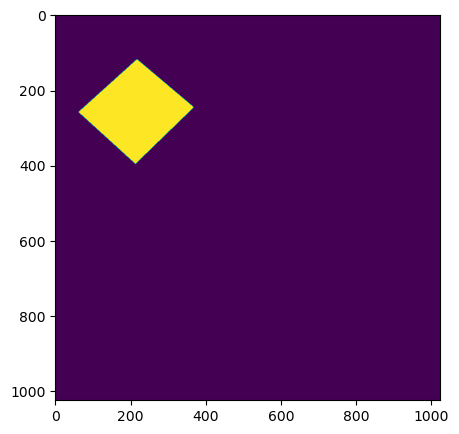

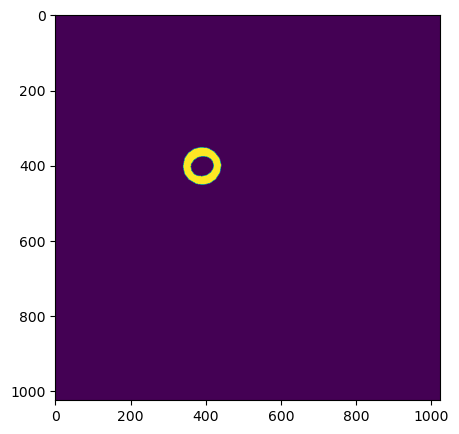

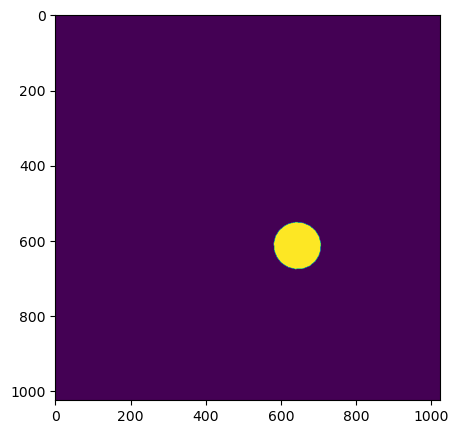

In [6]:
areas = []
# loop over all seg masks
for color in object_segmentation_colors:
    area = get_mask_area(im_seg, color)
    fig = plt.figure(figsize=[5, 5])
    ax = fig.add_subplot(111)
    ax.imshow(area)
    areas.append(area)

In [7]:
# counter = np.unique(im_seg.reshape(-1, im_seg.shape[2]), axis=0)
# num_obj = counter.shape[0]-1
# areas = []
# for color in counter:
#     if not np.array_equal(color,  np.array([0,0,0])):
#         area = get_mask_area(im_seg, color)
#         fig = plt.figure(figsize=[5, 5])
#         ax = fig.add_subplot(111)
#         ax.imshow(area)
#         areas.append(area)

In [8]:
# counter

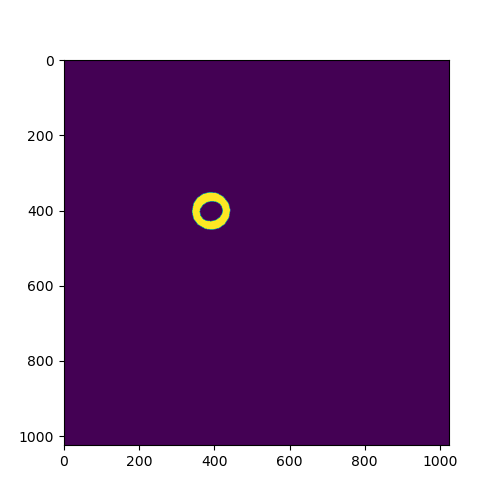

In [21]:
obj_idx = 1
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
ax.imshow(areas[obj_idx])


In [22]:
# pts = np.array(np.where(areas[obj_idx] == True)).T
# depth = depth_map[pts[:, 0], pts[:, 1]]
# pw = unproject_pixels(pts, depth, cam_matrix)

# pw = unproject_pixels(areas[obj_idx], depth_map, cam_matrix)
pw = unproject_pixels(np.flip(areas[obj_idx],1), np.flip(depth_map,1), cam_matrix)

intrinsics:  [[995.55562209   0.         512.        ]
 [  0.         995.55562209 512.        ]
 [  0.           0.           1.        ]]


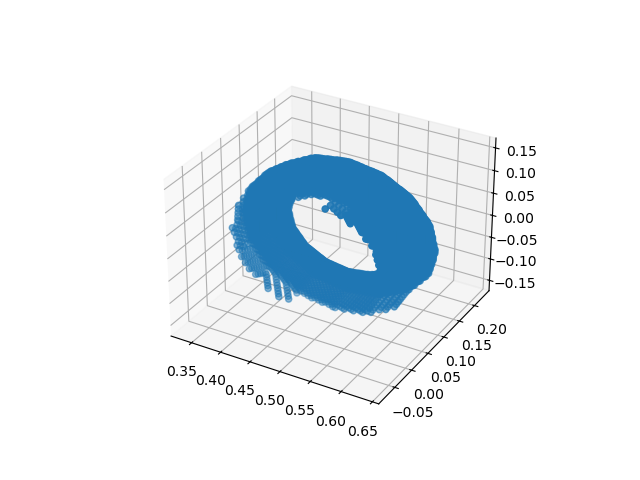

In [23]:
%matplotlib widget

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pw[:,0], pw[:,1], pw[:,2])
set_axes_equal(ax)

In [24]:
pw.mean(0)

array([ 0.48100433,  0.10737922, -0.00551229])

In [16]:
initial_position

array([[ 1.3,  0. ,  0. ],
       [ 0.5,  0. ,  0. ],
       [-0.5,  0. ,  0. ]], dtype=float32)

In [15]:
point_cloud_centroid = pw.mean(0)
point_cloud_bottom = min(pw[:,1])
object_pose = np.array([point_cloud_centroid[0], point_cloud_bottom, point_cloud_centroid[2]])
print("inferred pose: ", object_pose)

inferred pose:  [0.680286   0.00817053 0.3944522 ]


In [23]:
centroid = pw.mean(0)
bottom = min(pw[:,1])
print(centroid)
print(np.array([centroid[0], bottom, centroid[2]]))


[0.817993   0.01196645 0.26943324]
[0.817993   0.00595634 0.26943324]
